# PosRecoCNN Training

Position reconstruction CNN training pipeline for SBND detector.
Uses ResNet-18 architecture to predict particle positions from PMT data.

## 1. Setup and Configuration

In [1]:
# Essential imports only
import os
import sys
import numpy as np
import awkward as ak
import uproot
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit

# TensorFlow with GPU memory growth
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Configure GPU memory growth for JupyterHub
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
        print("🔧 GPU configured with memory growth for JupyterHub")
        print(f"Available GPU: {gpus[0]}")
    except RuntimeError as e:
        print(f"⚠️ GPU configuration warning: {e}")
else:
    print("⚠️ No GPU found")

# Auto-detect training directory based on project structure
def find_training_directory():
    """Find the training directory automatically based on project structure."""

    # Method 1: Check if we're already in the training directory
    if os.path.exists('config.py') and os.path.exists('utils.py'):
        return os.getcwd()

    # Method 2: Look for sbndcode structure from common paths
    possible_bases = [
        # Standard LArSoft development paths
        "/exp/sbnd/app/users/{}/larsoft_*/srcs/sbndcode",
        "/exp/sbnd/app/users/{}/*/srcs/sbndcode",
        # Alternative paths
        "/home/{}/sbndcode",
        "/home/{}/larsoft_*/srcs/sbndcode",
        # Current directory relatives
        "./sbndcode",
        "../sbndcode",
        "../../sbndcode",
    ]

    # Get current user
    import getpass
    username = getpass.getuser()

    # Expand paths with username and wildcards
    import glob
    expanded_paths = []
    for base in possible_bases:
        if '{}' in base:
            base = base.format(username)
        if '*' in base:
            expanded_paths.extend(glob.glob(base))
        else:
            expanded_paths.append(base)

    # Check each potential sbndcode directory
    for sbndcode_path in expanded_paths:
        training_path = os.path.join(sbndcode_path, "sbndcode", "PosRecoCVN", "training")
        if os.path.exists(training_path) and os.path.exists(os.path.join(training_path, "config.py")):
            return training_path

    # Method 3: Search upwards from current directory
    current = os.getcwd()
    for _ in range(5):  # Don't go too far up
        training_path = os.path.join(current, "sbndcode", "PosRecoCVN", "training")
        if os.path.exists(training_path) and os.path.exists(os.path.join(training_path, "config.py")):
            return training_path
        parent = os.path.dirname(current)
        if parent == current:  # reached root
            break
        current = parent

    return None

# Find and set training directory
print("🔍 Auto-detecting training directory...")
training_dir = find_training_directory()

if training_dir:
    print(f"✅ Found training directory: {training_dir}")
    if os.getcwd() != training_dir:
        print(f"📁 Changing directory from {os.getcwd()} to {training_dir}")
        os.chdir(training_dir)
else:
    print("❌ Could not find training directory automatically")
    print("🔧 Manual setup options:")
    print("1. Navigate to your training directory:")
    print("   os.chdir('/path/to/your/sbndcode/sbndcode/PosRecoCVN/training')")
    print("2. Or copy the required files:")
    print("   !cp /path/to/your/training/config.py .")
    print("   !cp /path/to/your/training/utils.py .")
    print("3. Or add your training directory to Python path:")
    print("   sys.path.append('/path/to/your/training/directory')")

# Add current directory to Python path
if os.getcwd() not in sys.path:
    sys.path.append(os.getcwd())

# Debug info
print(f"\nCurrent working directory: {os.getcwd()}")
print(f"config.py exists: {os.path.exists('config.py')}")
print(f"utils.py exists: {os.path.exists('utils.py')}")

# Try to import local modules
config_imported = False
utils_imported = False

try:
    from config import *
    config_imported = True
    print("✅ config module imported successfully")
except ImportError as e:
    print(f"❌ config import error: {e}")

try:
    from utils import *
    utils_imported = True
    print("✅ utils module imported successfully")
except ImportError as e:
    print(f"❌ utils import error: {e}")

if not (config_imported and utils_imported):
    print("\n🔧 If auto-detection failed, try one of these solutions:")
    print("1. Manual directory change:")
    print("   os.chdir('/exp/sbnd/app/users/YOUR_USERNAME/larsoft_*/srcs/sbndcode/sbndcode/PosRecoCVN/training')")
    print("2. Add to Python path:")
    print("   sys.path.append('/path/to/your/training/directory')")
    print("3. Copy files to current directory")
    print("\nThen restart this cell.")

# TensorFlow settings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

# Only run these if modules were imported successfully
if config_imported and utils_imported:
    print("🎯 PosRecoCNN Training Pipeline - GPU Mode")
    print_config_summary()
    validate_paths()
else:
    print("⚠️ Skipping configuration check until modules are properly imported")

2025-08-05 15:34:53.842801: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-08-05 15:34:53.842950: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-08-05 15:34:53.844950: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-08-05 15:34:53.851806: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


🔧 GPU configured with memory growth for JupyterHub
Available GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
🔍 Auto-detecting training directory...
✅ Found training directory: /exp/sbnd/app/users/svidales/larsoft_v10_06_01_develop/srcs/sbndcode/sbndcode/PosRecoCVN/training
📁 Changing directory from /home/svidales to /exp/sbnd/app/users/svidales/larsoft_v10_06_01_develop/srcs/sbndcode/sbndcode/PosRecoCVN/training

Current working directory: /exp/sbnd/app/users/svidales/larsoft_v10_06_01_develop/srcs/sbndcode/sbndcode/PosRecoCVN/training
config.py exists: True
utils.py exists: True
✅ config module imported successfully
✅ utils module imported successfully
🎯 PosRecoCNN Training Pipeline - GPU Mode
📋 Configuration Summary
PMT Maps Directory: /exp/sbnd/app/users/svidales/larsoft_v10_06_01_develop/srcs/sbndcode/sbndcode/PosRecoCVN/pmt_maps
Model Export Path: /exp/sbnd/data/users/svidales/AI_nuvT_project_support/cnn_models/v0508_trained_w_30k
Training Data: mc_MCP2025B_0

2025-08-05 15:35:00.235063: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-08-05 15:35:00.276468: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-08-05 15:35:00.276891: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

## 2. Data Loading

In [2]:
# Load training data
print("📂 Loading training data...")
import time
start_time = time.time()

file = uproot.open(DATA_CONFIG['training_file'])
optree = file['opanatree']['OpAnaTree']

if LOADING_CONFIG['load_all']:
    print(f"Loading all events: {optree.num_entries:,}")
    arrays = []
    for i, key in enumerate(DATA_CONFIG['keys_to_load']):
        print(f"  Loading {key}... ({i+1}/{len(DATA_CONFIG['keys_to_load'])}) [{100*(i+1)/len(DATA_CONFIG['keys_to_load']):.1f}%]")
        array = optree[key].array()
        arrays.append(array)
else:
    n_total = optree.num_entries
    n_load = int(n_total * LOADING_CONFIG['fraction'])
    start = LOADING_CONFIG['start_event']
    end = start + n_load
    print(f"Loading events {start}-{end} ({n_load:,}/{n_total:,})")
    arrays = []
    for i, key in enumerate(DATA_CONFIG['keys_to_load']):
        print(f"  Loading {key}... ({i+1}/{len(DATA_CONFIG['keys_to_load'])}) [{100*(i+1)/len(DATA_CONFIG['keys_to_load']):.1f}%]")
        array = optree[key].array(entry_start=start, entry_stop=end)
        arrays.append(array)

loading_time = time.time() - start_time

# Unpack arrays
f_ophit_PE, f_ophit_ch, f_ophit_t, nuvT, dEpromx, dEpromy, dEpromz, dEtpc, nuvZ = arrays

# Display loading statistics
print("✅ Data loaded successfully")
print(f"⏱️ Loading time: {loading_time:.2f} seconds")
print(f"📊 Loaded {len(arrays)} arrays:")
for i, key in enumerate(DATA_CONFIG['keys_to_load']):
    array = arrays[i]
    array_size_mb = array.nbytes / (1024*1024)
    print(f"   {key}: {len(array):,} events, {array_size_mb:.1f} MB")

total_size_mb = sum(array.nbytes for array in arrays) / (1024*1024)
print(f"📈 Total data size: {total_size_mb:.1f} MB")
print(f"⚡ Loading speed: {total_size_mb/loading_time:.1f} MB/s")

📂 Loading training data...


Loading all events: 497,317
  Loading flash_ophit_pe... (1/9) [11.1%]
  Loading flash_ophit_ch... (2/9) [22.2%]
  Loading flash_ophit_time... (3/9) [33.3%]
  Loading nuvT... (4/9) [44.4%]
  Loading dEpromx... (5/9) [55.6%]
  Loading dEpromy... (6/9) [66.7%]
  Loading dEpromz... (7/9) [77.8%]
  Loading dEtpc... (8/9) [88.9%]
  Loading nuvZ... (9/9) [100.0%]
✅ Data loaded successfully
⏱️ Loading time: 1329.99 seconds
📊 Loaded 9 arrays:
   flash_ophit_pe: 497,317 events, 9349.0 MB
   flash_ophit_ch: 497,317 events, 4681.6 MB
   flash_ophit_time: 497,317 events, 9349.0 MB
   nuvT: 497,317 events, 10.6 MB
   dEpromx: 497,317 events, 11.4 MB
   dEpromy: 497,317 events, 11.4 MB
   dEpromz: 497,317 events, 11.4 MB
   dEtpc: 497,317 events, 11.4 MB
   nuvZ: 497,317 events, 10.6 MB
📈 Total data size: 23446.5 MB
⚡ Loading speed: 17.6 MB/s


## 3. Channel Dictionary and Event Filtering

In [3]:
# Create channel dictionary
PDSMap = file['opanatree']['PDSMapTree']
ID = PDSMap['OpDetID'].array()
Type = PDSMap['OpDetType'].array()
channel_dict = {id_val: int(type_val) for id_val, type_val in zip(ID[0], Type[0])}
print(f"📡 Channel dictionary created: {len(channel_dict)} channels")

# Process events with centralized configuration
print("\n🔄 Processing events...")
results = process_events(
    nuvT, f_ophit_PE, f_ophit_ch, f_ophit_t,
    dEpromx, dEpromy, dEpromz, dEtpc, nuvZ,
    channel_dict, FILTER_CONFIG, verbose=True
)

# Unpack results
(nuvT_final, f_ophit_PE_final, f_ophit_ch_final, f_ophit_t_final,
 dEpromx_final, dEpromy_final, dEpromz_final, dEtpc_final, nuvZ_final, stats) = results

📡 Channel dictionary created: 312 channels

🔄 Processing events...
🚀 Starting optimized event processing...
Initial events: 497,317
Processing flashes...
Applying data validity cuts...
Applying energy cuts...
Applying position cuts...
✅ Processing completed in 7.58 seconds

Initial events: 497,317


,Cut,Removed,Remaining,Cumulative_Eff
0,Single neutrino,287236,210081,0.422
1,Has flashes,3316,206765,0.416
2,Valid data (≠ -999 in dEprom),323,206442,0.415
3,Energy cut,10370,196072,0.394
4,Position cut,847,195225,0.393


Final efficiency: 0.393 (195,225/497,317)

📊 Final dataset ranges:
  dEpromx: [-200.0, 200.0]
  dEpromy: [-199.8, 199.8]
  dEpromz: [4.6, 500.0]
  dEtpc: [50.0, 7571.2]


## 4. PE Matrix and Image Creation

In [4]:
# Create PE matrix
print("🔢 Creating PE matrix...")
pe_matrix = create_pe_matrix(f_ophit_PE_final, f_ophit_ch_final, IMAGE_CONFIG['max_channels'])

# Load PMT maps with relative paths
print("\n🗺️ Loading PMT maps...")
uncoated_map = np.loadtxt(DATA_CONFIG['pmt_maps']['uncoated'], delimiter=",", dtype=int)
coated_map = np.loadtxt(DATA_CONFIG['pmt_maps']['coated'], delimiter=",", dtype=int)
print(f"Uncoated map shape: {uncoated_map.shape}")
print(f"Coated map shape: {coated_map.shape}")

# Create images and store normalization factors
print("\n🖼️ Creating PE images...")
images, normalization_factors = create_pe_images(
    pe_matrix, uncoated_map, coated_map, 
    method=IMAGE_CONFIG['selection_method']
)

print(f"✅ Images created: {images.shape}")
print(f"📊 Normalization factors: {normalization_factors}")

🔢 Creating PE matrix...
Creating PE matrix for 195,225 events x 312 channels
  Processing event 0/195,225 (0.0%)


  Processing event 10,000/195,225 (5.1%)
  Processing event 20,000/195,225 (10.2%)
  Processing event 30,000/195,225 (15.4%)
  Processing event 40,000/195,225 (20.5%)
  Processing event 50,000/195,225 (25.6%)
  Processing event 60,000/195,225 (30.7%)
  Processing event 70,000/195,225 (35.9%)
  Processing event 80,000/195,225 (41.0%)
  Processing event 90,000/195,225 (46.1%)
  Processing event 100,000/195,225 (51.2%)
  Processing event 110,000/195,225 (56.3%)
  Processing event 120,000/195,225 (61.5%)
  Processing event 130,000/195,225 (66.6%)
  Processing event 140,000/195,225 (71.7%)
  Processing event 150,000/195,225 (76.8%)
  Processing event 160,000/195,225 (82.0%)
  Processing event 170,000/195,225 (87.1%)
  Processing event 180,000/195,225 (92.2%)
  Processing event 190,000/195,225 (97.3%)
✅ Completed in 171.17 seconds
Matrix shape: (195225, 312)
Non-zero elements: 26,898,643
Total PE: 3400410624.0

🗺️ Loading PMT maps...
Uncoated map shape: (118, 70)
Coated map shape: (118, 70)


## 5. Target Variable Preparation

In [5]:
# Prepare coordinates (use absolute x)
print("🎯 Preparing target variables...")
x_abs = np.abs(np.array(dEpromx_final).flatten())
y = np.array(dEpromy_final).flatten()
z = np.array(dEpromz_final).flatten()

coordinates = np.column_stack((x_abs, y, z))
print(f"Coordinate ranges before scaling:")
print(f"  X (abs): [{np.min(x_abs):.1f}, {np.max(x_abs):.1f}]")
print(f"  Y: [{np.min(y):.1f}, {np.max(y):.1f}]")
print(f"  Z: [{np.min(z):.1f}, {np.max(z):.1f}]")

# Scale coordinates using config
y_scaled = scale_coordinates(coordinates, COORD_CONFIG['ranges'])
print(f"\nScaled coordinate ranges:")
print(f"  X: [{np.min(y_scaled[:, 0]):.3f}, {np.max(y_scaled[:, 0]):.3f}]")
print(f"  Y: [{np.min(y_scaled[:, 1]):.3f}, {np.max(y_scaled[:, 1]):.3f}]")
print(f"  Z: [{np.min(y_scaled[:, 2]):.3f}, {np.max(y_scaled[:, 2]):.3f}]")

🎯 Preparing target variables...
Coordinate ranges before scaling:
  X (abs): [0.6, 200.0]
  Y: [-199.8, 199.8]
  Z: [4.6, 500.0]

Scaled coordinate ranges:
  X: [0.003, 1.000]
  Y: [-0.999, 0.999]
  Z: [0.009, 1.000]


## 6. Train/Validation Split

In [6]:
# Calculate split sizes (no test split - handled separately in inference)
n_total = len(y_scaled)
n_train = int(n_total * TRAINING_CONFIG['train_fraction'])
n_val = n_total - n_train  # Use remaining for validation

print(f"📊 Dataset splits:")
print(f"  Training: {n_train:,} ({100*n_train/n_total:.1f}%)")
print(f"  Validation: {n_val:,} ({100*n_val/n_total:.1f}%)")
print(f"  Test: Handled separately in PosRecoCNN_Inference notebook")

# Create splits
x_train = images[:n_train]
x_val = images[n_train:]

y_train = y_scaled[:n_train]
y_val = y_scaled[n_train:]

print(f"\n✅ Data splits created:")
print(f"  x_train: {x_train.shape}")
print(f"  x_val: {x_val.shape}")

📊 Dataset splits:
  Training: 165,941 (85.0%)
  Validation: 29,284 (15.0%)
  Test: Handled separately in PosRecoCNN_Inference notebook

✅ Data splits created:
  x_train: (165941, 59, 70, 2)
  x_val: (29284, 59, 70, 2)


## 7. Model Definition (ResNet-18 Architecture)

In [19]:
# Clear everything and restart model training from scratch
import gc
print("🧹 Clearing GPU memory and resetting model...")

# Clear Keras session completely
tf.keras.backend.clear_session()

# Force garbage collection
gc.collect()

# Delete existing model if it exists
try:
    del Model
    print("   Deleted existing model")
except:
    print("   No existing model to delete")

# Clear any existing variables that might interfere
try:
    del history
    print("   Deleted training history")
except:
    pass

print("✅ Memory and model cleared - ready for fresh training")

🧹 Clearing GPU memory and resetting model...
   Deleted existing model
   Deleted training history
✅ Memory and model cleared - ready for fresh training


In [20]:
# Define ResNet-18 architecture (keeping original as it works well)
def create_resnet18_model(input_shape, dropout_rate=0.4):
    """Create ResNet-18 model for position regression."""
    
    # Input layer
    input_layer = layers.Input(shape=input_shape)

    # Initial convolution layer
    x = layers.Conv2D(64, kernel_size=7, strides=2, padding='same', use_bias=False)(input_layer)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

    # Define the basic residual block
    def basic_block(input_tensor, filters, stride=1, downsample=False):
        shortcut = input_tensor

        x = layers.Conv2D(filters, kernel_size=3, strides=stride, padding='same', use_bias=False)(input_tensor)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)

        x = layers.Conv2D(filters, kernel_size=3, strides=1, padding='same', use_bias=False)(x)
        x = layers.BatchNormalization()(x)

        if downsample:
            shortcut = layers.Conv2D(filters, kernel_size=1, strides=stride, padding='same', use_bias=False)(input_tensor)
            shortcut = layers.BatchNormalization()(shortcut)

        x = layers.Add()([x, shortcut])
        x = layers.ReLU()(x)
        return x

    # ResNet-18 stages
    x = basic_block(x, 64)
    x = basic_block(x, 64)

    x = basic_block(x, 128, stride=2, downsample=True)
    x = basic_block(x, 128)

    x = basic_block(x, 256, stride=1, downsample=True)
    x = basic_block(x, 256)

    x = basic_block(x, 512, stride=1, downsample=True)
    x = basic_block(x, 512)

    # Global Average Pooling and output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(dropout_rate)(x)
    output = layers.Dense(3)(x)  # 3 coordinates: x, y, z

    return models.Model(inputs=input_layer, outputs=output)

# Create fresh model from scratch
print("🏗️ Creating fresh ResNet-18 model...")
input_shape = x_train.shape[1:]
Model = create_resnet18_model(input_shape, TRAINING_CONFIG['dropout_rate'])

print(f"✅ Fresh model created with input shape: {input_shape}")
print(f"📊 Total parameters: {Model.count_params():,}")
print("🔄 Model ready for training from scratch")

🏗️ Creating fresh ResNet-18 model...
✅ Fresh model created with input shape: (59, 70, 2)
📊 Total parameters: 11,184,515
🔄 Model ready for training from scratch


## 8. Training

In [21]:
# Display current training configuration
print("📋 Current Training Configuration:")
print("=" * 40)
print(f"  Epochs: {TRAINING_CONFIG['epochs']}")
print(f"  Batch size: {TRAINING_CONFIG['batch_size']}")
print(f"  Original patience: {TRAINING_CONFIG['patience']}")
print(f"  Reduce LR patience: {TRAINING_CONFIG['reduce_lr_patience']}")
print(f"  Reduce LR factor: {TRAINING_CONFIG['reduce_lr_factor']}")
print(f"  Min LR: {TRAINING_CONFIG['min_lr']}")
print(f"  Dropout rate: {TRAINING_CONFIG['dropout_rate']}")
print(f"  Optimizer: {TRAINING_CONFIG['optimizer']}")
print(f"  Loss: {TRAINING_CONFIG['loss']}")
print(f"  Metrics: {TRAINING_CONFIG['metrics']}")

# Adjust training configuration for stability
print("\n⚙️ Adjusting training parameters for stability...")
TRAINING_CONFIG['patience'] = 6  # Increase patience
TRAINING_CONFIG['batch_size'] = 64  # Increase batch size for stable BN
TRAINING_CONFIG['reduce_lr_patience'] = 3  # Reduce LR sooner
TRAINING_CONFIG['reduce_lr_factor'] = 0.5  # More aggressive LR reduction

print(f"Batch size changed to: {TRAINING_CONFIG['batch_size']}")
print(f"Early stopping patience: {TRAINING_CONFIG['patience']}")
print(f"Reduce LR patience: {TRAINING_CONFIG['reduce_lr_patience']}")
print(f"Reduce LR factor: {TRAINING_CONFIG['reduce_lr_factor']}")

# Create optimizer with lower initial learning rate
from tensorflow.keras.optimizers import Adam
optimizer = Adam(learning_rate=0.0005)  # Lower LR
print(f"Using lower initial learning rate: 0.0005")

# Setup callbacks
print("\n⚙️ Setting up training callbacks...")
callbacks = [
    ModelCheckpoint(
        MODEL_CONFIG['weights_file'],
        monitor='val_loss',
        verbose=1,  # Show when saving
        save_best_only=True,
        mode='min'
    ),
    EarlyStopping(
        monitor='val_loss',
        patience=TRAINING_CONFIG['patience'],
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=TRAINING_CONFIG['reduce_lr_factor'],
        patience=TRAINING_CONFIG['reduce_lr_patience'],
        min_lr=TRAINING_CONFIG['min_lr'],
        verbose=1
    )
]

# Recompile model with new optimizer
Model.compile(
    optimizer=optimizer,
    loss=TRAINING_CONFIG['loss'],
    metrics=TRAINING_CONFIG['metrics']
)

# Train model
print("🚀 Starting training with improved stability...")
history = Model.fit(
    x_train, y_train,
    epochs=TRAINING_CONFIG['epochs'],
    batch_size=TRAINING_CONFIG['batch_size'],
    callbacks=callbacks,
    validation_data=(x_val, y_val),
    verbose=1
)

print("✅ Training completed")

📋 Current Training Configuration:
  Epochs: 80
  Batch size: 32
  Original patience: 4
  Reduce LR patience: 5
  Reduce LR factor: 0.7
  Min LR: 1e-06
  Dropout rate: 0.2
  Optimizer: adam
  Loss: mean_squared_error
  Metrics: ['mse']

⚙️ Adjusting training parameters for stability...
Batch size changed to: 64
Early stopping patience: 6
Reduce LR patience: 3
Reduce LR factor: 0.5
Using lower initial learning rate: 0.0005

⚙️ Setting up training callbacks...
🚀 Starting training with improved stability...
Epoch 1/80
2593/2593 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.5091 - mse: 0.5091
Epoch 1: val_loss improved from inf to 0.05871, saving model to /tmp/weights_nuvT.hdf5.keras
2593/2593 ━━━━━━━━━━━━━━━━━━━━ 77s 24ms/step - loss: 0.5089 - mse: 0.5089 - val_loss: 0.0587 - val_mse: 0.0587 - learning_rate: 5.0000e-04
Epoch 2/80
2591/2593 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0129 - mse: 0.0129
Epoch 2: val_loss did not improve from 0.05871
2593/2593 ━━━━━━━━━━━━━━━━━━━━ 46s 18ms/step

## 9. Training History Visualization

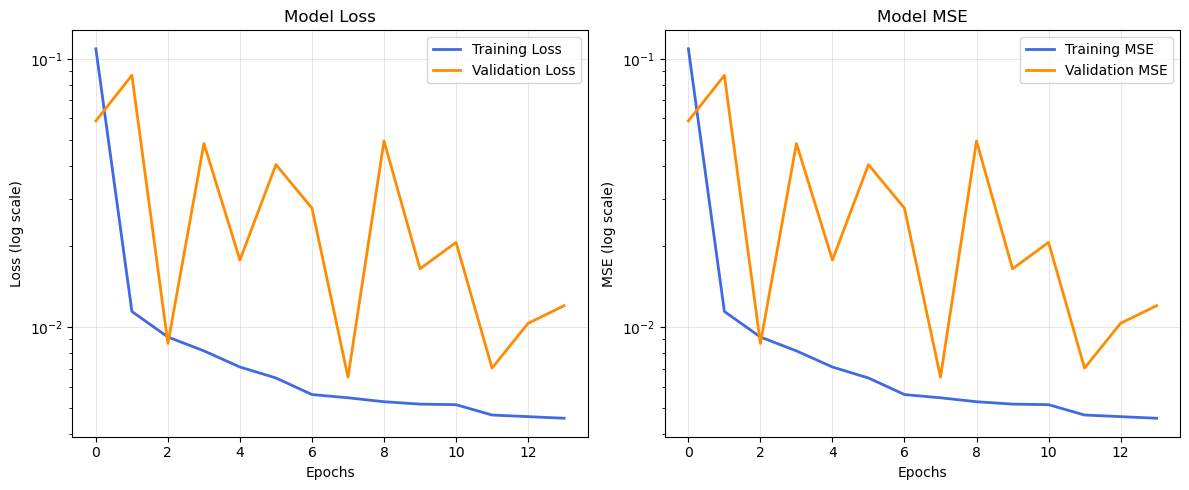

📊 Final Training Loss: 0.004574
📊 Final Validation Loss: 0.012019


In [22]:
# Plot training history
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss', color='royalblue', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', color='darkorange', linewidth=2)
plt.yscale('log')
plt.xlabel('Epochs')
plt.ylabel('Loss (log scale)')
plt.title('Model Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# MSE plot
plt.subplot(1, 2, 2)
plt.plot(history.history['mse'], label='Training MSE', color='royalblue', linewidth=2)
plt.plot(history.history['val_mse'], label='Validation MSE', color='darkorange', linewidth=2)
plt.yscale('log')
plt.xlabel('Epochs')
plt.ylabel('MSE (log scale)')
plt.title('Model MSE')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print final metrics
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]
print(f"📊 Final Training Loss: {final_train_loss:.6f}")
print(f"📊 Final Validation Loss: {final_val_loss:.6f}")

## 10. Model Export

In [28]:
# Export trained model for inference
import json
import gc

print("💾 Exporting trained model for inference...")

# Create export directory
export_path = get_model_export_path(len(y_train))
os.makedirs(export_path, exist_ok=True)

# Export the model in SavedModel format for TensorFlow Serving
model_save_path = os.path.join(export_path, 'saved_model')
Model.export(model_save_path)  # SavedModel format for TF Serving
print(f"   📁 Model exported in SavedModel format: {model_save_path}")

# Convert numpy types to native Python types for JSON serialization
def convert_numpy_types(obj):
    """Convert numpy types to native Python types for JSON serialization."""
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, (np.float32, np.float64)):
        return float(obj)
    elif isinstance(obj, (np.int32, np.int64)):
        return int(obj)
    elif isinstance(obj, dict):
        return {key: convert_numpy_types(value) for key, value in obj.items()}
    elif isinstance(obj, list):
        return [convert_numpy_types(item) for item in obj]
    return obj

# Save normalization factors and coordinate ranges for inference
inference_config = {
    'normalization_factors': convert_numpy_types(normalization_factors),
    'coord_ranges': convert_numpy_types(COORD_CONFIG['ranges']),
    'image_config': {
        'max_channels': IMAGE_CONFIG['max_channels'],
        'selection_method': IMAGE_CONFIG['selection_method']
    },
    'model_info': {
        'epochs_trained': len(history.history['loss']),
        'final_val_loss': float(final_val_loss),  # Convert to native float
        'training_events': len(y_train),
        'validation_events': len(y_val)
    }
}

# Save configuration files
norm_file = os.path.join(export_path, 'normalization_factors.json')
shared_norm_file = '/exp/sbnd/data/users/svidales/AI_nuvT_project_support/cnn_models/normalization_factors.json'

with open(norm_file, 'w') as f:
    json.dump(inference_config, f, indent=2)

# Also save to shared location for easy access
os.makedirs(os.path.dirname(shared_norm_file), exist_ok=True)
with open(shared_norm_file, 'w') as f:
    json.dump(inference_config, f, indent=2)

print(f"✅ Model exported successfully:")
print(f"   📁 SavedModel: {model_save_path}")
print(f"   📄 Config: {norm_file}")
print(f"   📄 Shared config: {shared_norm_file}")
print(f"   📊 Trained on {len(y_train):,} events")

💾 Exporting trained model for inference...
INFO:tensorflow:Assets written to: /exp/sbnd/data/users/svidales/AI_nuvT_project_support/cnn_models/v0508_trained_w_30k/v0805_trained_w_165k/saved_model/assets


INFO:tensorflow:Assets written to: /exp/sbnd/data/users/svidales/AI_nuvT_project_support/cnn_models/v0508_trained_w_30k/v0805_trained_w_165k/saved_model/assets


Saved artifact at '/exp/sbnd/data/users/svidales/AI_nuvT_project_support/cnn_models/v0508_trained_w_30k/v0805_trained_w_165k/saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 59, 70, 2), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  140302788371808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140304243804640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140302788366000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140302788369872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140302788366528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140302788375680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140303644392992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140303644389824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140304243807984: TensorSpec(shape=(), dtype=tf.resource

## 11. Prediction

In [29]:
# Make predictions on validation set
print("🔮 Making predictions on validation set...")
y_pred_scaled = Model.predict(x_val)

# Convert back to original coordinates
y_pred_original = inverse_scale_coordinates(y_pred_scaled, COORD_CONFIG['ranges'])
y_val_original = inverse_scale_coordinates(y_val, COORD_CONFIG['ranges'])

print(f"✅ Predictions completed for {len(y_val):,} validation events")
print(f"Prediction ranges:")
print(f"  X: [{np.min(y_pred_original[:, 0]):.1f}, {np.max(y_pred_original[:, 0]):.1f}]")
print(f"  Y: [{np.min(y_pred_original[:, 1]):.1f}, {np.max(y_pred_original[:, 1]):.1f}]")
print(f"  Z: [{np.min(y_pred_original[:, 2]):.1f}, {np.max(y_pred_original[:, 2]):.1f}]")

🔮 Making predictions on validation set...
916/916 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step
✅ Predictions completed for 29,284 validation events
Prediction ranges:
  X: [-14.8, 219.5]
  Y: [-205.6, 210.9]
  Z: [1.5, 556.8]


## 12. Model Evaluation on Validation Set

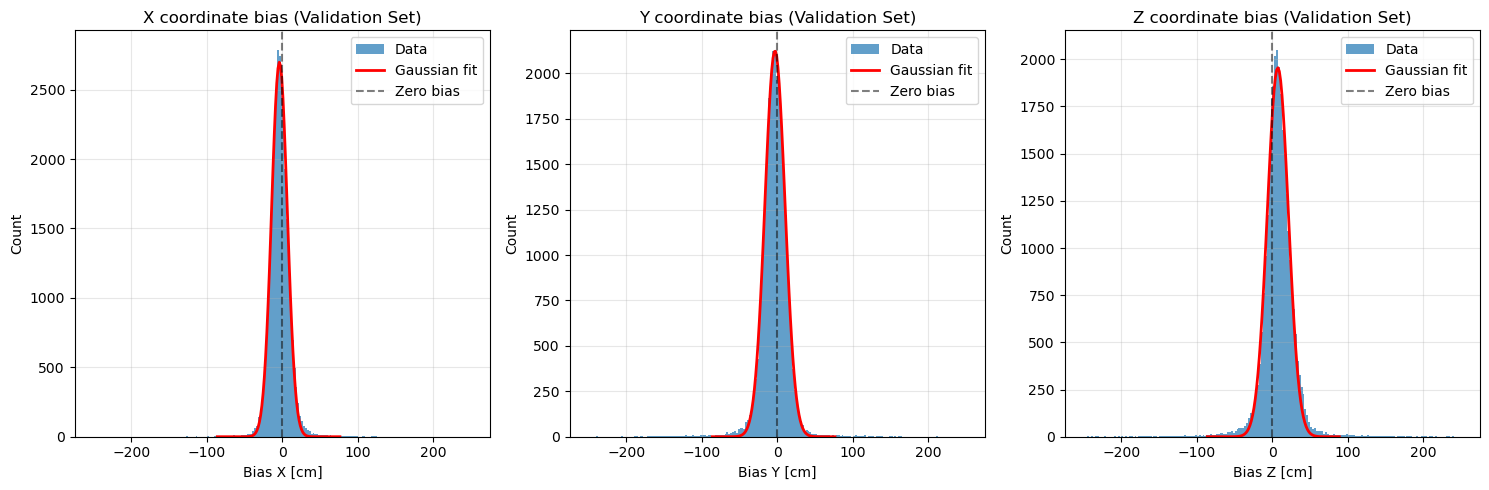


📊 Validation Set Bias Analysis Results:
X coordinate:
  Mean bias: -3.92 cm
  Resolution (σ): 10.42 cm

Y coordinate:
  Mean bias: -3.21 cm
  Resolution (σ): 13.31 cm

Z coordinate:
  Mean bias: 7.21 cm
  Resolution (σ): 14.00 cm



In [30]:
# Calculate differences (bias) and perform Gaussian fits
diff_coords = y_pred_original - y_val_original
coord_names = ['X', 'Y', 'Z']

# Gaussian fit function
def gaussian(x, a, x0, sigma):
    return a * np.exp(-(x - x0)**2 / (2 * sigma**2))

# Bias analysis plots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
bias_results = {}

for i, coord in enumerate(coord_names):
    diff = diff_coords[:, i]
    config = ANALYSIS_CONFIG['bias_analysis']
    
    # Create histogram
    counts, bins, _ = axs[i].hist(
        diff, 
        config['hist_bins'], 
        range=config['hist_ranges'][coord],
        alpha=0.7,
        label='Data'
    )
    
    # Prepare for Gaussian fit
    bin_centers = (bins[:-1] + bins[1:]) / 2
    fit_range = config['fit_ranges'][coord]
    
    # Fit Gaussian
    try:
        p0 = [np.max(counts), 0, 50]
        popt, _ = curve_fit(
            gaussian, 
            bin_centers[fit_range[0]:fit_range[1]], 
            counts[fit_range[0]:fit_range[1]], 
            p0=p0
        )
        
        # Plot fit
        x_fit = np.linspace(bin_centers[fit_range[0]], bin_centers[fit_range[1]], 100)
        y_fit = gaussian(x_fit, *popt)
        axs[i].plot(x_fit, y_fit, 'r-', linewidth=2, label='Gaussian fit')
        
        # Store results
        bias_results[coord] = {
            'mean': popt[1],
            'sigma': popt[2]
        }
        
    except Exception as e:
        print(f"Warning: Could not fit Gaussian for {coord}: {e}")
        bias_results[coord] = {
            'mean': np.mean(diff),
            'sigma': np.std(diff)
        }
    
    axs[i].axvline(0, color='black', linestyle='--', alpha=0.5, label='Zero bias')
    axs[i].set_xlabel(f'Bias {coord} [cm]')
    axs[i].set_ylabel('Count')
    axs[i].set_title(f'{coord} coordinate bias (Validation Set)')
    axs[i].legend()
    axs[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print bias results
print("\n📊 Validation Set Bias Analysis Results:")
print("=" * 40)
for coord in coord_names:
    mean = bias_results[coord]['mean']
    sigma = bias_results[coord]['sigma']
    print(f"{coord} coordinate:")
    print(f"  Mean bias: {mean:.2f} cm")
    print(f"  Resolution (σ): {sigma:.2f} cm")
    print()

## 13. Bias Analysis (Validation Set)

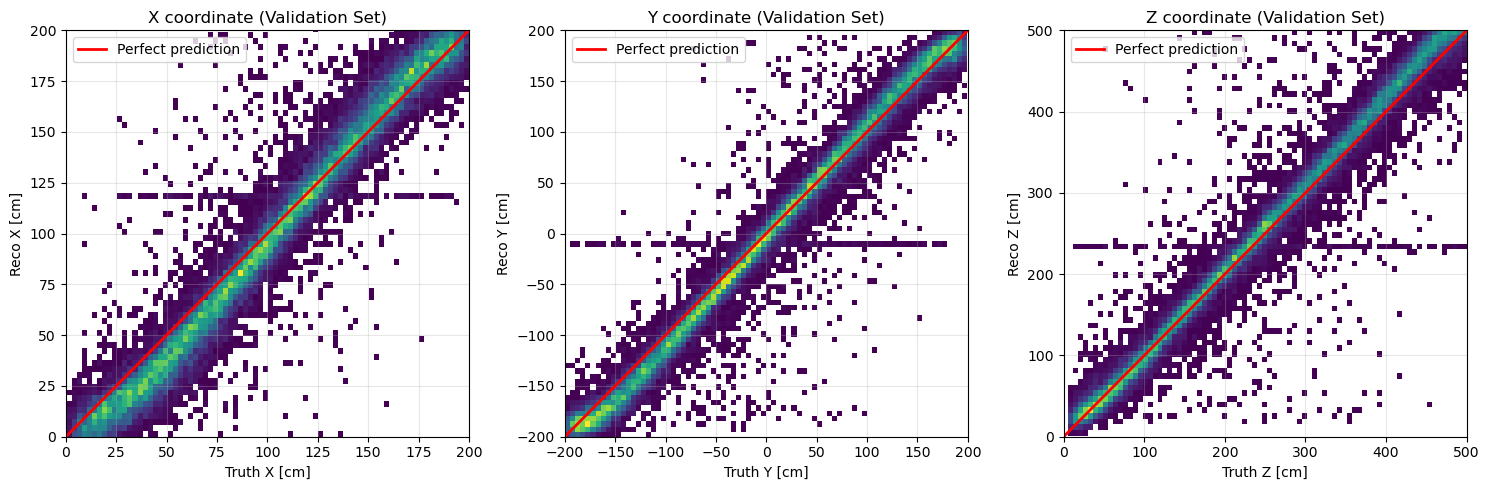

In [32]:
# Reconstructed vs Truth comparison plots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
coord_names = ['X', 'Y', 'Z']
coord_limits = [(0, 200), (-200, 200), (0, 500)]

for i, (coord, limits) in enumerate(zip(coord_names, coord_limits)):
    hist, xedges, yedges = np.histogram2d(
        y_val_original[:, i],
        y_pred_original[:, i],
        bins=ANALYSIS_CONFIG['reco_truth_comparison']['bins']
    )
    
    hist_masked = np.ma.masked_equal(hist, 0)
    
    im = axs[i].pcolormesh(
        xedges, yedges, hist_masked.T,
        cmap=ANALYSIS_CONFIG['reco_truth_comparison']['cmap'],
        shading='auto'
    )
    
    axs[i].plot(limits, limits, 'r-', linewidth=2, label='Perfect prediction')
    axs[i].set_xlim(limits)
    axs[i].set_ylim(limits)
    axs[i].set_xlabel(f'Truth {coord} [cm]')
    axs[i].set_ylabel(f'Reco {coord} [cm]')
    axs[i].set_title(f'{coord} coordinate (Validation Set)')
    axs[i].grid(True, alpha=0.3)
    axs[i].legend()

plt.tight_layout()
plt.show()

# Calculate and display performance metrics
mse_per_coord = np.mean((y_pred_original - y_val_original)**2, axis=0)
rmse_per_coord = np.sqrt(mse_per_coord)
mae_per_coord = np.mean(np.abs(y_pred_original - y_val_original), axis=0)

## 14. Training Summary and Next Steps

In [33]:
print("🎉 Training Pipeline Completed Successfully!")
print("=" * 50)
print(f"📊 Dataset: {len(y_train):,} training events")
print(f"📊 Validation: {len(y_val):,} validation events")
print(f"🏗️ Model: ResNet-18 architecture")
print(f"💾 Model saved to: {export_path}")
print(f"📈 Final validation loss: {final_val_loss:.6f}")
print(f"📏 Validation RMSE: {overall_rmse:.2f} cm")

print("\n📊 Validation Performance Summary:")
for coord in coord_names:
    mean = bias_results[coord]['mean']
    sigma = bias_results[coord]['sigma']
    print(f"  {coord}: Bias = {mean:.2f} cm, Resolution = {sigma:.2f} cm")

print("\n📋 For test set evaluation and inference:")
print("1. Use PosRecoCNN_Inference notebook")
print("2. Load independent test data")  
print("3. Apply same preprocessing pipeline")
print("4. Compare test vs validation performance")

print(f"\n📁 Files created:")
print(f"  - Model: {export_path}")
print(f"  - Normalization factors: {norm_file}")
print(f"  - Best weights: {MODEL_CONFIG['weights_file']}")

print(f"\n🔄 Next steps:")
print(f"  1. Run PosRecoCNN_Inference notebook for unbiased test evaluation")
print(f"  2. Compare test vs validation metrics")
print(f"  3. Deploy model for production inference")

# Clean up memory
del x_train, x_val, y_train, y_val, images, pe_matrix
gc.collect()
print(f"\n🧹 Memory cleaned up")

🎉 Training Pipeline Completed Successfully!
📊 Dataset: 165,941 training events
📊 Validation: 29,284 validation events
🏗️ Model: ResNet-18 architecture
💾 Model saved to: /exp/sbnd/data/users/svidales/AI_nuvT_project_support/cnn_models/v0508_trained_w_30k/v0805_trained_w_165k
📈 Final validation loss: 0.012019
📏 Validation RMSE: 22.27 cm

📊 Validation Performance Summary:
  X: Bias = -3.92 cm, Resolution = 10.42 cm
  Y: Bias = -3.21 cm, Resolution = 13.31 cm
  Z: Bias = 7.21 cm, Resolution = 14.00 cm

📋 For test set evaluation and inference:
1. Use PosRecoCNN_Inference notebook
2. Load independent test data
3. Apply same preprocessing pipeline
4. Compare test vs validation performance

📁 Files created:
  - Model: /exp/sbnd/data/users/svidales/AI_nuvT_project_support/cnn_models/v0508_trained_w_30k/v0805_trained_w_165k
  - Normalization factors: /exp/sbnd/data/users/svidales/AI_nuvT_project_support/cnn_models/v0508_trained_w_30k/v0805_trained_w_165k/normalization_factors.json
  - Best weigh